In [1]:
import re
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
with open("traceroute.txt") as f:
    buf = f.read()

In [3]:
parts = [p for p in  buf.split("START") if p not in [""]]

In [4]:
def dump_to_tuple(dump):
    
    """
    Converts a raw traceroute data-dump into a summarized tuple.
    """
    
    # timestamp
    lines = [l for l in dump.split("\n") if l not in [ "" ] ]
    timestamp = int( lines[0])
    
    # first line (beside the timestamp)
    l1 = lines[1]
    # last line 
    last = lines[-1]
    
    try:
        ip1 = re.match(".*\((.*)\).*", l1).group(1)
        ip2 = re.match(".*\((.*)\).*", last).group(1)
    except:
        pass
    
    # check if target was reached 
    reached = ip1==ip2!=None
    
    # number of hops
    hops = int(last [:4] )
    
    # target latency (ms)
    try:    
        times = re.findall("\d+.\d+ ms", last)
        times = [float(t.replace("ms", "")) for t in times ]
        latency = sum(times)/len(times)
    except:
        latency = None
    
    return (timestamp, hops, reached, latency)

# Convert dumps to dataframe

In [5]:
tuples = [dump_to_tuple(p) for p in parts]

In [6]:
df = pd.DataFrame(tuples, columns=["timestamp", "hops", "reached", "latency"])

## Re-format timestamp

In [7]:
df["timestamp"] = pd.to_datetime(df.timestamp, unit="s")

In [8]:
df = df.set_index("timestamp")

## Group readings by hour (get mean)

In [9]:
# TODO: group by hour once you have enough data
# group the same hour from different days!
df = df.resample("1min").aggregate("mean")
# variance could be of interest as well (higher variance => network is unstable):
# df = df.resample("1min").aggregate("var")

In [10]:
df

,hops,reached,latency
timestamp,,,
2022-04-06 15:07:00,12.6,0.600000,53.032200
2022-04-06 15:08:00,12.9,0.550000,58.047200
2022-04-06 15:09:00,12.5,0.611111,56.559315
2022-04-06 15:10:00,13.0,0.444444,73.089296


<AxesSubplot:xlabel='timestamp', ylabel='latency (ms)'>

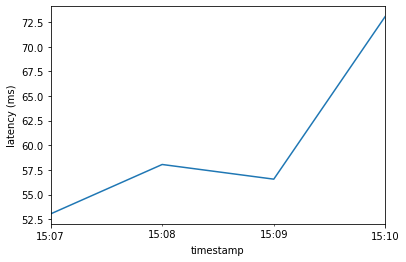

In [11]:
plt.ylabel("latency (ms)")
df.latency.plot()

<AxesSubplot:xlabel='timestamp', ylabel='drop-rate'>

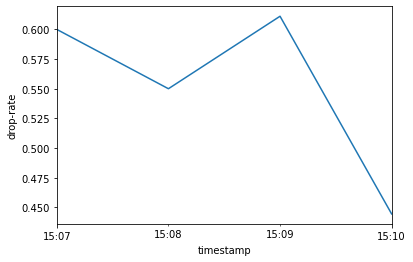

In [12]:
plt.ylabel("drop-rate")
df.reached.plot()

<AxesSubplot:xlabel='timestamp', ylabel='hops'>

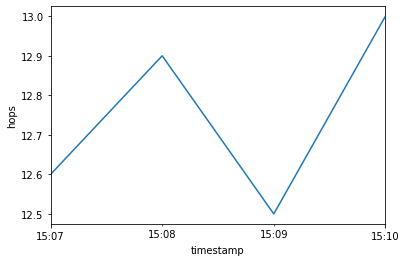

In [13]:
plt.ylabel("hops")
df.hops.plot()